<span style="color: green; font-size: 40px; font-weight: bold;">Projeto 3 (Parte 2)</span>

<br>

<span style="color: green; font-size: 40px; font-weight: bold;">Sistema de Recomendação em Tempo Real</span>

<br> <br>

# Importante

> É necessário que a célula da etapa `Criação do Kafka Producer e Envio de Dados para o Kafka` da **Parte 1** do projeto esteja rodando.

<br><br><br>

# Importando Pacotes

<br>

In [1]:
# Imports
import os
import time
import random
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler

# Imports
import os
import ujson
import spotipy
import spotipy.util
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import re

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

<br><br>

# 1. Configuração do Kafka e Spark

In [2]:
# Endereço do servidor Kafka
SERVER = 'localhost:9092'

# Nome do tópico
TOPIC = "dsaminiprojeto7"

# Conectores do Spark para o Apache Kafka
spark_jars =  ("{},{},{},{},{}".format(os.getcwd() + "/jars/spark-sql-kafka-0-10_2.12-3.3.2.jar",  
                                       os.getcwd() + "/jars/kafka-clients-2.8.0.jar", 
                                       os.getcwd() + "/jars/spark-streaming-kafka-0-10-assembly_2.12-3.3.2.jar", 
                                       os.getcwd() + "/jars/commons-pool2-2.8.0.jar",  
                                       os.getcwd() + "/jars/spark-token-provider-kafka-0-10_2.12-3.1.2.jar"))

print('Etapa concluída.')

Etapa concluída.


In [3]:
# Endereço do servidor Kafka
SERVER = 'localhost:9092'

# Nome do tópico
TOPIC = "dsaminiprojeto7"

# Conectores do Spark para o Apache Kafka
spark_jars =  ("{},{},{},{},{}".format(os.getcwd() + "/jars/novas_versoes/spark-sql-kafka-0-10_2.12-3.5.1.jar",  
                                       os.getcwd() + "/jars/novas_versoes/kafka-clients-3.5.1.jar", 
                                       os.getcwd() + "/jars/novas_versoes/spark-streaming-kafka-0-10-assembly_2.12-3.5.1.jar", 
                                       os.getcwd() + "/jars/novas_versoes/commons-pool2-2.11.0.jar",  
                                       os.getcwd() + "/jars/novas_versoes/spark-token-provider-kafka-0-10_2.12-3.5.1.jar"))

print('Etapa concluída.')

Etapa concluída.


In [4]:
import pyspark
print(pyspark.__version__)

3.5.1


**Explicação**: Configura o endereço do servidor Kafka, o nome do tópico, e define os jars necessários para conectar o Spark ao Kafka. Para conectar o Spark Streaming no Apache Kafka precisamos de conectores (`jars`), que estão disponíveis através de arquivos .jar já incluso no projeto.

<br><br>

# 2. Inicialização da Sessão Spark

In [5]:
# Inicializa sessão Spark
spark = SparkSession \
        .builder \
        .config("spark.jars", spark_jars) \
        .appName("Mini-Projeto7") \
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

print('Etapa concluída.')

24/09/02 17:40:16 WARN Utils: Your hostname, eduardo-Inspiron-15-3520 resolves to a loopback address: 127.0.1.1; using 192.168.0.13 instead (on interface wlp0s20f3)
24/09/02 17:40:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/09/02 17:40:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Etapa concluída.


**Explicação**: Inicializa uma sessão Spark com os jars configurados, definindo o nome da aplicação e ajustando o nível de log.

<br><br>

# 3. Leitura do Streaming de Dados do Kafka

Esta etapa é para `dados em tempo real`.

In [6]:
# Usamos o Spark Streaming para leitura do streaming de dados do Kafka e salvamos em um dataframe
df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", SERVER) \
        .option("subscribe", TOPIC) \
        .option("startingOffsets", "latest") \
        .load()

print(df)

print('\nEtapa concluída.')

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

Etapa concluída.


**Explicação**: Lê o streaming de dados do Kafka, utilizando o Spark Streaming, e armazena em um DataFrame.

#### Explicação mais detalhada:

- **Parte 1**: Na parte 1 do projeto, foi criado um `Kafka Producer que envia mensagens (dados de músicas) para um tópico Kafka (dsaminiprojeto7)`. Cada mensagem representa uma música e é enviada para o Kafka em formato de string.

- **Parte 2**: O código na Parte 2, especificamente na seção de "Leitura do Streaming de Dados do Kafka", está utilizando o Spark Streaming para consumir essas mesmas mensagens que foram enviadas para o Kafka.

<br>

**Nota Importante**: Você pode seguir em frente com o projeto enquanto o Kafka Producer ainda está enviando as músicas na `Parte 1`. No entanto, se você prosseguir com o Spark Streaming antes que todas as músicas tenham sido enviadas, o sistema de recomendação funcionará apenas com as músicas que já foram enviadas até aquele momento, e não com o dataset completo. Além disso, não é necessário repetir esse processo de envio todas as vezes que rodar o projeto, a menos que deseje processar novos dados ou reiniciar todo o fluxo.

<br><br>

# 4. Processamento e Transformação de Dados

In [7]:
# Selecionamos a coluna timestamp como string e salvamos em um novo dataframe
df1 = df.selectExpr("CAST(value AS STRING)", "timestamp")

print(type(df1))

<class 'pyspark.sql.dataframe.DataFrame'>


**Explicação**:

- **Função**: Esta célula seleciona a coluna `value` do DataFrame `df`, que contém as mensagens do Kafka, e a converte de bytes para string usando o comando `CAST`. Isso é necessário porque as mensagens do Kafka são recebidas como bytes e precisam ser decodificadas para serem manipuladas.
- **Resultado**: O resultado é um novo DataFrame `df1` que contém duas colunas: `value` (convertido para string) e `timestamp` (que registra o momento em que a mensagem foi recebida).

<br>

In [8]:
# Definimos o schema com o nome de cada coluna e o tipo de dado
def_schema = "order_id INT, id STRING, name STRING, popularity INT, duration_ms DOUBLE, " \
             + "artists STRING, id_artists STRING, release_date STRING, " \
             + "danceability DOUBLE,energy DOUBLE, key INT, loudness DOUBLE, " \
             + "mode INT,speechiness DOUBLE," \
             + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
             + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"

# Selecionamos o streaming de dados de acordo com o schema e salvamos em um novo dataframe
df2 = df1.select(from_csv(col("value"), def_schema).alias("song"), "timestamp")

df2

DataFrame[song: struct<order_id:int,id:string,name:string,popularity:int,duration_ms:double,artists:string,id_artists:string,release_date:string,danceability:double,energy:double,key:int,loudness:double,mode:int,speechiness:double,acousticness:double,instrumentalness:double,liveness:double,valence:double,tempo:double,time_signature:double>, timestamp: timestamp]

**Explicação**:

- **Função**: Primeiro, define o `def_schema`, que especifica o esquema (ou estrutura) dos dados dentro da coluna `value`. Isso inclui os nomes das colunas e seus respectivos tipos de dados.
- **Conversão**: Em seguida, a célula aplica este esquema aos dados da coluna `value` do DataFrame `df1` usando a função `from_csv`. Esta função converte a string `value` em um conjunto de colunas estruturadas de acordo com o esquema definido.
- **Resultado**: O novo DataFrame `df2` possui uma coluna `song`, que é uma estrutura (struct) contendo todas as colunas definidas no esquema, além da coluna `timestamp` que foi mantida. 

<br>

In [9]:
# Criamos uma view na memória do Spark e visualizamos o schema
df3 = df2.select("song.*", "timestamp")  
df3.createOrReplaceTempView("df3_View")

df3.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [10]:
# Não podemos visualizar ainda, pois temos que gerar o stream do Spark Streaming
# df3.show()

**Explicação**:

- **Função**: Nesta célula, o código desestrutura a coluna song em colunas individuais usando `df2.select("song.*", "timestamp")`, criando um novo DataFrame `df3` que contém todas as colunas da estrutura `song` mais a coluna ``timestamp`.
- **View Temporária**: A célula então cria uma view temporária chamada `df3_View` na memória do Spark, permitindo que você faça consultas SQL diretamente sobre esses dados.
- **Exibição do Schema**: Por fim, a função printSchema exibe a estrutura das colunas e seus tipos de dados no DataFrame `df3`, ajudando a confirmar que os dados foram corretamente transformados e estruturados.

<br>

**Resumo**: Transforma os dados do streaming em colunas estruturadas, define o schema, e cria uma view temporária para consultas SQL.

<br><br>

# 5. Consulta e Visualização dos Dados em Tempo Real

<br>

> Nesta seção, você configurará o Spark Streaming para consultar e visualizar os dados em `tempo real à medida que eles chegam do Kafka`.

> Os dados só poderão ser `visualizados caso estejam sendo consumidos em tempo real no script da` **Parte 1** `deste projeto`.

<br>

### 5.1 Seleção dos Dados com as Músicas do Stream

In [11]:
# Selecionamos os dados com as músicas do stream
musicas_stream = spark.sql("SELECT * FROM df3_View")

print('Dados selecionados.')

Dados selecionados.


**Explicação**:

- **Função**: Esta linha executa uma consulta SQL no Spark para selecionar todos os dados da view temporária `df3_View` que foi criada anteriormente.
- **Resultado**: O resultado é um DataFrame chamado `musicas_stream`, que contém todos os dados estruturados das músicas que foram processadas e armazenadas na view `df3_View`.

<br>

### 5.2 Criação e Configuração do Stream de Dados no Spark Streaming

In [12]:
# Parar todas as consultas de streaming ativas
for stream in spark.streams.active:
    stream.stop()

# Criar o stream de dados no Spark Streaming com modo 'append'
musicas_stream_spark = musicas_stream \
    .writeStream \
    .trigger(processingTime='5 seconds') \
    .outputMode("append") \
    .option("truncate", "false") \
    .format("memory") \
    .queryName("tabela_spark") \
    .start()

print('Processo concluído.')

Processo concluído.


**Explicação**:

- **Função Geral**: Este bloco de código configura e inicia um stream de dados usando Spark Streaming, que permite processar dados em tempo real.
- **writeStream**: O método writeStream indica que você está criando um fluxo de saída (stream) a partir do DataFrame musicas_stream.
- **trigger(processingTime = '5 seconds')**: Define o intervalo de tempo para processar novos dados. Neste caso, o Spark verificará novos dados a cada 5 segundos e os processará.
- **outputMode("append")**: Especifica que os novos dados serão adicionados ao stream existente sem substituir os dados anteriores. Ou seja, os dados novos são "acrescentados" ao final do stream.
- **option("truncate", "false")**: Esta opção evita que os dados sejam truncados quando exibidos no console ou armazenados na memória. Isso é útil para garantir que você veja todos os dados completos.
- **format("memory")**: Especifica que os dados do stream serão mantidos na memória, permitindo consultas rápidas. Esse é um formato útil para visualização e depuração de dados em tempo real.
- **queryName("tabela_spark")**: Define um nome para a consulta do stream. Isso cria uma tabela temporária chamada tabela_spark que pode ser consultada usando SQL enquanto o stream estiver ativo.
- **start()**: Inicia o stream de dados. A partir deste ponto, o Spark começa a processar e armazenar os dados conforme eles chegam, de acordo com as configurações definidas.

<br>

### 5.3 Espera pela Terminação

In [13]:
musicas_stream_spark.awaitTermination(2)

False

**Explicação**:

- **Função**: Este comando faz com que o código aguarde por 2 segundos a execução do stream antes de prosseguir.
- **Uso Prático**: Isso é útil para permitir que o stream processe alguns dados iniciais e, ao mesmo tempo, dar ao desenvolvedor a oportunidade de ver o comportamento do stream de forma controlada.

<br>

### 5.4 Visualizando os Dados

In [14]:
# Selecionamos e Visualizando as músicas da tabela de stream do Spark
spark_songs = spark.sql("SELECT * FROM tabela_spark")

# Agora sim podemos visualizar o stream em tempo real como tabela do Spark
spark_songs.show(5)

+--------+---+----+----------+-----------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+---------+
|order_id| id|name|popularity|duration_ms|artists|id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|timestamp|
+--------+---+----+----------+-----------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+---------+
+--------+---+----+----------+-----------+-------+----------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+---------+



In [15]:
# Podemos visualizar apenas algumas colunas, por exemplo
spark_songs.select('order_id', 'id', 'name', 'popularity', 'duration_ms', 'artists').show(5)

+--------+---+----+----------+-----------+-------+
|order_id| id|name|popularity|duration_ms|artists|
+--------+---+----+----------+-----------+-------+
+--------+---+----+----------+-----------+-------+



In [16]:
# Contagem de músicas extraídas em tempo real
spark_songs.count()

0

**Explicação**: Se o valor acima for **zero** significa que não estamos consumindo dados em tempo real no momento.

<br><br>

# 6. Consulta e Visualização dos Dados em Modo Batch


> **Importante**: A `etapa 6` realiza as `etapas 3 e 4 em uma única célula`, pois combina a leitura dos dados do Kafka em modo batch (semelhante ao que é feito na etapa 3, que usa o Spark Streaming para ler os dados em tempo real) com o processamento e transformação dos dados (que foi feito na etapa 4 para estruturar e aplicar um schema).

> Nesta seção, você configurará a leitura dos dados do Kafka em `modo batch, o que significa que todos os dados desde o início até o último offset disponível no Kafka serão lidos de uma vez`.

<br>

In [17]:
# Verificando
if spark_songs.count() == 0:
    print("\nO DataFrame `spark_songs` está vazio. Vamos carregar os dados em modo batch.\n")
    
    # Configuração para leitura dos dados do Kafka em modo batch
    df_batch = spark \
        .read \
        .format("kafka") \
        .option("kafka.bootstrap.servers", SERVER) \
        .option("subscribe", TOPIC) \
        .option("startingOffsets", "earliest") \
        .option("endingOffsets", "latest") \
        .load()

    # Converte os dados do Kafka (em bytes) para string e aplica o schema
    df1_batch = df_batch.selectExpr("CAST(value AS STRING)", "timestamp")

    # Aplica o schema que você definiu anteriormente na etapa 4
    df2_batch = df1_batch.select(from_csv(col("value"), def_schema).alias("song"), "timestamp")

    # Seleciona as colunas estruturadas para visualizar
    spark_songs = df2_batch.select("song.*", "timestamp")

    # Visualiza os dados
    spark_songs.show(5, truncate=False)
else:
    print("\nO DataFrame `spark_songs` tem dados.\n")


O DataFrame `spark_songs` está vazio. Vamos carregar os dados em modo batch.



+--------+----------------------+-------------+----------+-----------+--------------------+--------------------------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------------------+
|order_id|id                    |name         |popularity|duration_ms|artists             |id_artists                            |release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |time_signature|timestamp              |
+--------+----------------------+-------------+----------+-----------+--------------------+--------------------------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------------------+
|0       |22a0Ji6EQKkY0tBohlN4Od|There You Are|2         |231240.0   |KirstenLudwig       |qLyYYhSlsjwymwVKwW                    |2018-0

In [18]:
# Exibe o nome das colunas do DataFrame `spark_songs`
print("Colunas de `spark_songs`:")
print(spark_songs.columns)

Colunas de `spark_songs`:
['order_id', 'id', 'name', 'popularity', 'duration_ms', 'artists', 'id_artists', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'timestamp']


In [19]:
# Conta o número de linhas no DataFrame `df_final`
num_linhas = spark_songs.count()

# Exibe a quantidade de linhas
print(f"O DataFrame `spark_songs` contém {num_linhas} linhas.")

O DataFrame `spark_songs` contém 174308 linhas.


**Explicação**: Acima é visualizado os dados quando estão em **modo batch**.

<br><br>

# 7. Extração de Dados do Spotify

In [52]:
## Aqui você coloca as suas chaves da API do Spotify
os.environ["SPOTIPY_CLIENT_ID"] = '7c12416f4d564bc38825057a508a49b1'
os.environ["SPOTIPY_CLIENT_SECRET"] = '93dfa86e2546437d980ed78d7951e128'
os.environ["SPOTIPY_REDIRECT_URI"] = 'http://localhost:7777/callback'

# Escopo de extração das preferências do usuário
scope = 'user-library-read'

# Username no Spotify (inclua_aqui_seu_email_spotify)
username = 'eduardonitcheroy@gmail.com'

# Criação do tohen de acesso
token = spotipy.util.prompt_for_user_token(username, scope)

# Cria o objeto de autenticação
spotipy_obj = spotipy.Spotify(auth = token)

# Extrai até 50 músicas da lista de favoritos do usuário (limite máximo da api é 50)
saved_tracks = spotipy_obj.current_user_saved_tracks(limit = 50)

# Número total de músicas na lista de favoritos do usuário
n_tracks = saved_tracks['total']
print(f'Total de Músicas na Lista de Favoritos: {n_tracks}')

# Número de músicas extraídas neste lote
n_extracted = len(saved_tracks['items'])
print(f'\nNúmero de Músicas Extraídas para o Sistema de Recomendação: {n_extracted}')

# Tipo do Objeto
print('\nTipo do Objeto: ', type(saved_tracks))

print('\nEtapa concluída.')

Total de Músicas na Lista de Favoritos: 163

Número de Músicas Extraídas para o Sistema de Recomendação: 50

Tipo do Objeto:  <class 'dict'>

Etapa concluída.


### Explicação

- Configura e autentica  a API do Spotify para na sequência extrair as músicas favoritas do usuário.

<br><br>

# 8. Processamento de Atributos das Músicas

<br><br>

### 8.1 Extração e Formatação dos Atributos das Músicas

Transformar o objeto lista `saved_tracks` extraído na `etapa 7` e converter para `dataframe do pandas`.

In [21]:
## Visualiza Nome dos Atributos do objeto saved_tracks

# Obter as chaves do primeiro item na lista de músicas salvas para visualizar os atributos disponíveis
if 'items' in saved_tracks and len(saved_tracks['items']) > 0:
    # O 'track' contém as informações da música
    track_attributes = saved_tracks['items'][0]['track'].keys()
    print("Atributos disponíveis em 'saved_tracks['items'][0]['track']':")
    print(list(track_attributes))
else:
    print("Nenhuma música foi encontrada em 'saved_tracks'.")

Atributos disponíveis em 'saved_tracks['items'][0]['track']':
['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri']


In [22]:
# Cria Função para extrair os atributos selecionados do objeto saved_tracks da lista de músicas do usuário
def select_features(track_response):
    return {        
        'id': str(track_response['track']['id']),
        'name': str(track_response['track']['name']),
        'artists': ', '.join([artist['name'] for artist in track_response['track']['artists']]),  # Remove colchetes e junta nomes com vírgula
        'popularity': track_response['track']['popularity']
    }

# Aplica a função
tracks = [select_features(track) for track in saved_tracks['items']]

# Criamos o dataframe do pandas
df_tracks = pd.DataFrame(tracks)

# Visualiza linhas
df_tracks

,id,name,artists,popularity
0,6ZcNZYOqWfS2dYw7hLeQXK,Spending My Time,Roxette,46
1,1kvq7ksGQWSyRysYYNd6lu,Home Sweet Home,Mötley Crüe,68
2,4s686onxhVJEKyQ9gnx9IE,High Hopes - Live At Pompeii 2016,David Gilmour,45
3,6IYLjqSKQ4ma8FwlZd9LLI,Rattle That Lock,David Gilmour,46
4,0M8rrUcBYXa24y3AIKQ19z,Comfortably Numb - Live At Pompeii 2016,David Gilmour,53
5,3MrRksHupTVEQ7YbA0FsZK,The Final Countdown,Europe,76
6,6Zo58fraaPpTUUdYHwH0sf,Por Enquanto - Ao Vivo,Cássia Eller,69
7,4lwUIfJPyeKqGhG9KtHtIv,O Segundo Sol,Cássia Eller,61
8,1X95pCQG939KCbJL6yVQgw,Evidências,Chitãozinho & Xororó,66
9,7h8fXKTOWxJ96FrTkcdcoo,Certas Coisas,Lulu Santos,51


### Explicação:

- **Nesta etapa**, o código extrai os principais atributos das músicas favoritas do usuário a partir da API do Spotify, como `id`, `name`, `artists`, e `popularity`. Os nomes dos artistas são formatados como uma string única, removendo os colchetes. Em seguida, os dados são organizados em um DataFrame do pandas para facilitar futuras análises.

- **Resumo**: Os atributos das músicas são extraídos, formatados, e organizados em um `DataFrame do Pandas` para uso posterior.

<br><br>

### 8.2 Extração e Processamento de Atributos de Áudio

In [23]:
# Cria Dicionário para os Atributos de Áudio
audio_features = {}

# Extrai os atributos de áudio para cada música no `df_tracks` usando o `spotipy_obj`
for idd in df_tracks['id'].tolist():
    audio_features[idd] = spotipy_obj.audio_features(idd)[0]

# Adicionamos os atributos de áudio ao DataFrame `df_tracks`
df_tracks['acousticness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['acousticness'])
df_tracks['speechiness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['speechiness'])
df_tracks['key'] = df_tracks['id'].apply(lambda idd: str(audio_features[idd]['key']))
df_tracks['liveness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['liveness'])
df_tracks['instrumentalness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['instrumentalness'])
df_tracks['energy'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['energy'])
df_tracks['tempo'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['tempo'])
df_tracks['loudness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['loudness'])
df_tracks['danceability'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['danceability'])
df_tracks['valence'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['valence'])

# Visualiza as primeiras linhas do DataFrame atualizado
df_tracks.head()

,id,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
0,6ZcNZYOqWfS2dYw7hLeQXK,Spending My Time,Roxette,46,0.2380,0.0292,4,0.127,0.000115,0.574,170.549,-5.149,0.420,0.218
1,1kvq7ksGQWSyRysYYNd6lu,Home Sweet Home,Mötley Crüe,68,0.0983,0.0381,5,0.189,0.000004,0.776,76.301,-6.339,0.397,0.127
2,4s686onxhVJEKyQ9gnx9IE,High Hopes - Live At Pompeii 2016,David Gilmour,45,0.5330,0.0298,0,0.969,0.000401,0.395,73.958,-12.288,0.426,0.135
3,6IYLjqSKQ4ma8FwlZd9LLI,Rattle That Lock,David Gilmour,46,0.3250,0.0422,0,0.165,0.000000,0.620,120.069,-11.620,0.710,0.786
4,0M8rrUcBYXa24y3AIKQ19z,Comfortably Numb - Live At Pompeii 2016,David Gilmour,53,0.0260,0.0495,11,0.754,0.003820,0.641,127.142,-10.240,0.211,0.251


### Explicação:

- **Extração de Atributos de Áudio**: O código percorre a lista de IDs das músicas extraídas e consulta a API do Spotify para obter os atributos de áudio de cada música (como `acousticness`, `speechiness`, `energy`, entre outros).
- **Atualização do DataFrame**: Esses atributos de áudio são então adicionados ao DataFrame `df_tracks`, resultando em um conjunto de dados que inclui tanto os metadados das músicas (nome, artista, popularidade) quanto seus atributos de áudio.

**Resumo**: Extrai atributos das músicas e armazena em um DataFrame Pandas.

<br><br>

### 8.3 Integração com os Dados do Spark Streaming

Finalmente, integramos os dados de áudio extraídos do Spotify com os dados de músicas que podem estar `sendo processados em um fluxo de dados do Spark Streaming ou em Modo Batch`.

**Lembrando que** `spark_songs` são as músicas para indicar enquanto `df_tracks` são as 50 músicas favoritas extraídas da lista do spotify do usuário.

#### Verificando Nome das Colunas dos Dataframes `df_tracks` e `spark_songs`

In [24]:
# Exibe o nome das colunas do DataFrame `df_tracks`
print("Colunas de `df_tracks` após a integração:")
print(df_tracks.columns)

# Exibe o nome das colunas do DataFrame `spark_songs`
print("\nColunas de `spark_songs`:")
print(spark_songs.columns)

print('\n')


# Verifica as colunas presentes em df_tracks que não estão em spark_songs
colunas_diferentes_df_tracks = set(df_tracks.columns) - set(spark_songs.columns)

# Verifica as colunas presentes em spark_songs que não estão em df_tracks
colunas_diferentes_spark_songs = set(spark_songs.columns) - set(df_tracks.columns)

# Exibe as colunas diferentes, se existirem
if colunas_diferentes_df_tracks:
    print("Colunas em `df_tracks` que não estão em `spark_songs`:")
    print(colunas_diferentes_df_tracks)
else:
    print("Não há colunas em `df_tracks` que sejam diferentes de `spark_songs`.")

if colunas_diferentes_spark_songs:
    print("\nColunas em `spark_songs` que não estão em `df_tracks`:")
    print(colunas_diferentes_spark_songs)
else:
    print("\nNão há colunas em `spark_songs` que sejam diferentes de `df_tracks`.")

Colunas de `df_tracks` após a integração:
Index(['id', 'name', 'artists', 'popularity', 'acousticness', 'speechiness',
       'key', 'liveness', 'instrumentalness', 'energy', 'tempo', 'loudness',
       'danceability', 'valence'],
      dtype='object')

Colunas de `spark_songs`:
['order_id', 'id', 'name', 'popularity', 'duration_ms', 'artists', 'id_artists', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'timestamp']


Não há colunas em `df_tracks` que sejam diferentes de `spark_songs`.

Colunas em `spark_songs` que não estão em `df_tracks`:
{'release_date', 'id_artists', 'duration_ms', 'mode', 'time_signature', 'timestamp', 'order_id'}


<br>**Explicação**: Essa célula verifica se as colunas dos dados extraídos do Spotify (`df_tracks)` e do Spark Streaming (`spark_songs`) estão alinhadas. 

**Isso é importante para garantir que as duas fontes de dados possam ser combinadas corretamente**, evitando problemas de incompatibilidade quando forem unidas em um único DataFrame para análise ou recomendações.

<br>

#### Prepara os dados do Spark Streaming para integração

In [25]:
# Remove colunas desnecessárias do DataFrame `spark_songs` para que fique alinhado com `df_tracks`
df_final = spark_songs.drop('order_id', 
                            'mode', 
                            'release_date', 
                            'id_artists',
                            'time_signature', 
                            'duration_ms',
                            'timestamp')

# Exibe as primeiras linhas do DataFrame resultante da integração
df_final.show(5)

+--------------------+-------------+----------+--------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|                  id|         name|popularity|             artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+--------------------+-------------+----------+--------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|22a0Ji6EQKkY0tBoh...|There You Are|         2|       KirstenLudwig|       0.487| 0.707|  9|  -5.596|     0.0304|       0.334|           0.282|   0.105|  0.316|129.856|
|4J39ZEbwqHwtWLImU...|      88 Days|         8|    SaraKingIanOlney|       0.335| 0.401|  3| -10.749|     0.0333|       0.134|           0.582|   0.134|  0.233|155.062|
|0a12d4HUjOmQSqHqL...|     Castaway|         0|              ARZLEE|       0.553| 0.422|  1|  -11.29|     0.0314|        0.11|         3.25E-5|   0.119|   

In [26]:
# Conta o número de linhas no DataFrame `df_final`
num_linhas = df_final.count()

# Exibe a quantidade de linhas
print(f"O DataFrame `df_final` contém {num_linhas} linhas.")

O DataFrame `df_final` contém 174308 linhas.


### Explicação:

- **Integração com Spark Streaming**: As colunas desnecessárias dos dados do Spark são removidas e, em seguida, os dados de músicas do Spotify (incluindo a música selecionada aleatoriamente) são concatenados com os dados do Spark, resultando em um DataFrame `df_final` que contém tanto as músicas do streaming quanto a música do Spotify.

Essas etapas completam a integração e o processamento dos dados, preparando-os para análises mais avançadas ou para o uso em sistemas de recomendação.

<br><br>

# 9. Pré-Processamento de Dados para Machine Learning

<br>

#### Converte para para um Dataframe do Pandas para aplicar `Função Análise Inicial`

In [27]:
# Verifica classe de df_final
print(type(df_final))

# Converte o DataFrame df_final para um DataFrame do Pandas
df_final_pandas = df_final.toPandas()

# Verifica Tipo do novo objeto
print(type(df_final_pandas))

<class 'pyspark.sql.dataframe.DataFrame'>


<class 'pandas.core.frame.DataFrame'>


<br>

#### Aplica Função Análise Inicial

In [28]:
def funcao_analise_inicial(df):
    # Configurar Pandas para exibir todas as linhas
    pd.set_option('display.max_rows', None)

    # Informações do DataFrame
    print('\n\n INFO \n\n')
    df.info()
    print('\n\n ------------------------------------------------------------------------------------------ \n\n')

    # Verifica se há valores ausentes e duplicados
    valores_ausentes = df.isna().sum().sum() > 0
    valores_duplicados = df.duplicated().sum() > 0

    # Nomes das variáveis com valores ausentes
    variaveis_ausentes = df.columns[df.isna().any()].tolist()

    # Número de linhas duplicadas
    num_linhas_duplicadas = df.duplicated().sum()

    # Porcentagem de linhas duplicadas
    porcentagem_linhas_duplicadas = (num_linhas_duplicadas / len(df)) * 100

    # Exibe o resultado sobre valores ausentes e duplicados
    print("\n\nExistem valores ausentes:", valores_ausentes)
    if valores_ausentes:
        print("\nVariáveis com valores ausentes:", variaveis_ausentes)
    else:
        print("\nNenhuma variável possui valores ausentes.")

    print("\n\nExistem valores duplicados:", valores_duplicados)
    if valores_duplicados:
        print("\nNúmero de Linhas Duplicadas:", num_linhas_duplicadas)
        print("\nPorcentagem de Linhas Duplicadas: {:.2f}%".format(porcentagem_linhas_duplicadas))
    else:
        print("\nNenhuma variável possui valores duplicados.")
    
    # Verificação de caracteres especiais
    caracteres_especiais = re.compile('[@_!#$%^&*<>()?/\\|}{~:]')   # nenhum caracter removido
    colunas_com_caracteres_especiais = {}

    for coluna in df.columns:
        if df[coluna].dtype == 'object':  # Verifica apenas colunas de texto
            contem_caracteres_especiais = df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False)).any()
            if contem_caracteres_especiais:
                indices_com_caracteres_especiais = df[coluna][df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False))].index.tolist()
                colunas_com_caracteres_especiais[coluna] = indices_com_caracteres_especiais

    # Exibe o resultado sobre caracteres especiais
    print("\n\nExistem caracteres especiais nas colunas:", bool(colunas_com_caracteres_especiais))
    if colunas_com_caracteres_especiais:
        print("\nColunas com caracteres especiais e os índices:")
        for coluna, indices in colunas_com_caracteres_especiais.items():
            print(f"\n Coluna [ {coluna} ]: Índices com caracteres especiais {indices}")
    else:
        print("\nNenhuma coluna possui caracteres especiais.")

print('A função foi criada com sucesso.\n')

funcao_analise_inicial(df_final_pandas)

A função foi criada com sucesso.



 INFO 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174308 entries, 0 to 174307
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                174308 non-null  object 
 1   name              174308 non-null  object 
 2   popularity        159096 non-null  float64
 3   artists           171177 non-null  object 
 4   danceability      166240 non-null  float64
 5   energy            171821 non-null  float64
 6   key               159596 non-null  float64
 7   loudness          174061 non-null  float64
 8   speechiness       174267 non-null  float64
 9   acousticness      174285 non-null  float64
 10  instrumentalness  174293 non-null  float64
 11  liveness          174302 non-null  float64
 12  valence           174305 non-null  float64
 13  tempo             174307 non-null  float64
dtypes: float64(11), object(3)
memory usage: 18.6+ MB


 -------------------

<br>

### Excluindo Valores Ausentes e Convertendo de Volta para um DataFrame do PySpark

In [29]:
# Excluir todas as linhas com valores ausentes
df_final_pandas_sem_ausentes = df_final_pandas.dropna()

# Converter o DataFrame do Pandas de volta para um DataFrame do PySpark
df_final_limpo = spark.createDataFrame(df_final_pandas_sem_ausentes)

# Verifica classe de df_final
print(type(df_final_limpo))

# Exibe a quantidade de linhas
print(f"\nO DataFrame `df_final` contém {df_final_limpo.count()} linhas.")

<class 'pyspark.sql.dataframe.DataFrame'>



O DataFrame `df_final` contém 155923 linhas.


<br>

### Aplica Vector Dense e Padronização

In [30]:
# Configura o VectorAssembler com as colunas escolhidas para criar o vetor de características
vetor = VectorAssembler(inputCols = ['danceability',
                                     'energy',
                                     'loudness',
                                     'speechiness',
                                     'acousticness',
                                     'instrumentalness',
                                     'liveness',
                                     'valence',
                                     'tempo'], 
                        outputCol = 'song_features')

# Descarta valores inválidos/nulos durante a transformação para evitar problemas na montagem dos vetores
assembled = vetor.setHandleInvalid("skip").transform(df_final_limpo)

# Configura o StandardScaler para padronizar as características das músicas
std = StandardScaler(inputCol = 'song_features', outputCol = 'standardized')

# Treina o StandardScaler usando os dados montados
scale = std.fit(assembled)

# Aplica o scaler aos dados para obter as características padronizadas
df = scale.transform(assembled)

# Visualiza primeiras linhas
df.show(2)

+--------------------+-------------+----------+----------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|                  id|         name|popularity|         artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|       song_features|        standardized|
+--------------------+-------------+----------+----------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|22a0Ji6EQKkY0tBoh...|There You Are|       2.0|   KirstenLudwig|       0.487| 0.707|9.0|  -5.596|     0.0304|       0.334|           0.282|   0.105|  0.316|129.856|[0.487,0.707,-5.5...|[2.84287675016776...|
|4J39ZEbwqHwtWLImU...|      88 Days|       8.0|SaraKingIanOlney|       0.335| 0.401|3.0| -10.749|     0.0333|       0.134|           0.582|   0.134|  0.233|155.062|[0.335,0

In [31]:
## Visualizando como Dataframe do Pandas (apenas para visualização)

# Converte o DataFrame do PySpark para um DataFrame do Pandas
df_pandas_temp = df.toPandas()

# Exibe as primeiras linhas do DataFrame do Pandas
display(df_pandas_temp.head(2))

,id,name,popularity,artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_features,standardized
0,22a0Ji6EQKkY0tBohlN4Od,There You Are,2.0,KirstenLudwig,0.487,0.707,9.0,-5.596,0.0304,0.334,0.282,0.105,0.316,129.856,"[0.487, 0.707, -5.596, 0.0304, 0.334, 0.282, 0...","[2.8428767501677603, 2.7276228350149117, -1.08..."
1,4J39ZEbwqHwtWLImUKmrn9,88 Days,8.0,SaraKingIanOlney,0.335,0.401,3.0,-10.749,0.0333,0.134,0.582,0.134,0.233,155.062,"[0.335, 0.401, -10.749, 0.0333, 0.134, 0.582, ...","[1.9555723024767961, 1.5470675485728143, -2.08..."


### Explicação


- **Esta etapa** realiza através da `funcao_analise_inicial` uma verificação inicial dos dados e realiza `limpeza nos dados ausentes`, aplica as técnicas de Vetorização (Vector Assembler) e Padronização (StandardScaler) ao DataFrame `df_final_limpo`. Ele cria um novo DataFrame chamado `df`, que contém as mesmas colunas de `df_final_limpo`, além de duas novas colunas: `song_features`, que contém os valores das características vetorizadas, e `standardized`, que contém os valores vetorizados após a padronização.

<br><br>

# 10. Treinamento do Modelo de Machine Learning Não Supervisionado

<br>

#### Verificando Número Ideal Para `k` e Cria o Modelo

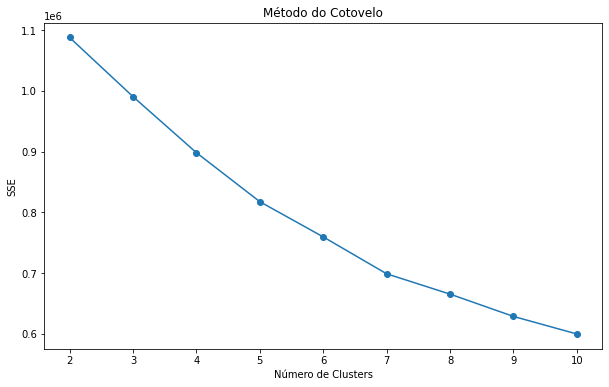

In [32]:
# Avaliar o método do cotovelo para encontrar o número ótimo de clusters (´k´)
sse = []
for k in range(2, 11):  # O loop agora começa em 2
    kmeans = KMeans(featuresCol='standardized', k=k)
    model = kmeans.fit(df)
    sse.append(model.summary.trainingCost)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [33]:
# Cria o objeto do modelo
objeto_KMeans = KMeans(featuresCol = 'standardized', k = 3)

# Treina o modelo
modelo_KMeans = objeto_KMeans.fit(df)

# Previsões do modelo
df_output = modelo_KMeans.transform(df)

print(type(df_output))
print(display(df_output.head(2)))

<class 'pyspark.sql.dataframe.DataFrame'>


[Row(id='22a0Ji6EQKkY0tBohlN4Od', name='There You Are', popularity=2.0, artists='KirstenLudwig', danceability=0.487, energy=0.707, key=9.0, loudness=-5.596, speechiness=0.0304, acousticness=0.334, instrumentalness=0.282, liveness=0.105, valence=0.316, tempo=129.856, song_features=DenseVector([0.487, 0.707, -5.596, 0.0304, 0.334, 0.282, 0.105, 0.316, 129.856]), standardized=DenseVector([2.8429, 2.7276, -1.0853, 0.2713, 0.9015, 0.9671, 0.621, 1.2227, 4.2598]), prediction=1),
 Row(id='4J39ZEbwqHwtWLImUKmrn9', name='88 Days', popularity=8.0, artists='SaraKingIanOlney', danceability=0.335, energy=0.401, key=3.0, loudness=-10.749, speechiness=0.0333, acousticness=0.134, instrumentalness=0.582, liveness=0.134, valence=0.233, tempo=155.062, song_features=DenseVector([0.335, 0.401, -10.749, 0.0333, 0.134, 0.582, 0.134, 0.233, 155.062]), standardized=DenseVector([1.9556, 1.5471, -2.0846, 0.2972, 0.3617, 1.9959, 0.7925, 0.9016, 5.0867]), prediction=0)]

None


<br>

#### Verificando Desempenho da Clusterização

from sklearn.metrics import silhouette_score

# Converter df_output para DataFrame do Pandas para usar com o silhouette_score
df_output_pandas = df_output.select('standardized', 'prediction').toPandas()

# Extraia as características padronizadas e os rótulos de clusters
X = np.array(df_output_pandas['standardized'].tolist())
labels = df_output_pandas['prediction'].values

# Calcular a pontuação de silhueta
silhouette_avg = silhouette_score(X, labels)
print(f'Pontuação de Silhueta: {silhouette_avg:.2f}')

<br>

### Preparando Dataset Final

In [34]:
# Selecionando as Colunas
datalabel = df_output.select('id',
                             'name',
                             'artists',
                             'danceability',
                             'energy',
                             'key',
                             'loudness',
                             'speechiness',
                             'acousticness',
                             'instrumentalness',
                             'liveness',
                             'valence',
                             'tempo',
                             'prediction')

# Realizando uma Limpeza Final
df_final = datalabel.toPandas()
df_final.drop(df_final[df_final['artists'] == '0'].index, inplace = True)
df_final.drop_duplicates(inplace = True)
df_final.drop(df_final[df_final['danceability'] == 0.0000].index, inplace = True)
df_final.drop(df_final[df_final['liveness'] == 0.000].index, inplace = True)
df_final.drop(df_final[df_final['instrumentalness'] == 0.000000].index, inplace = True)
df_final.drop(df_final[df_final['energy'] == 0.0000].index, inplace = True)
df_final.drop(df_final[df_final['danceability'] == 0.000].index, inplace = True)
df_final.drop(df_final[df_final['valence'] == 0.000].index, inplace = True)

display(df_final.head(4))

# Quantidade de linhas
df_final.shape[0]

,id,name,artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,prediction
0,22a0Ji6EQKkY0tBohlN4Od,There You Are,KirstenLudwig,0.487,0.707,9.0,-5.596,0.0304,0.3340,0.282000,0.1050,0.316,129.856,1
1,4J39ZEbwqHwtWLImUKmrn9,88 Days,SaraKingIanOlney,0.335,0.401,3.0,-10.749,0.0333,0.1340,0.582000,0.1340,0.233,155.062,0
2,0a12d4HUjOmQSqHqLopWYx,Castaway,ARZLEE,0.553,0.422,1.0,-11.290,0.0314,0.1100,0.000032,0.1190,0.290,83.988,1
4,0u7JZm9ORerlZnnxxSdMwl,Lonely,Hayleau,0.670,0.709,8.0,-3.921,0.0406,0.0169,0.000630,0.0542,0.577,98.954,1


113208

<br>

### Verificando se música da lista de favorito (`df_tracks`) está no Dataset Final (`df_final`)

In [37]:
# Verificando se alguma música de df_tracks está em df_final com base nas colunas 'id', 'name', e 'artists'
musicas_em_comum = df_tracks[
    df_tracks[['id', 'name', 'artists']].apply(
        lambda row: ((df_final['id'] == row['id']) |
                     (df_final['name'] == row['name']) | 
                     (df_final['artists'] == row['artists'])
                    ).any(), axis=1
    )
]

# Exibindo o resultado
if not musicas_em_comum.empty:
    print('\n')
    #print("As seguintes músicas estão presentes em ambos os dataframes:")
    #display(musicas_em_comum)
else:
    print("Nenhuma música de df_tracks está presente em df_final.")
    
# Exibindo o resultado e verificando as duplicações
print(f"Total de músicas encontradas: {musicas_em_comum.shape[0]}")



Total de músicas encontradas: 37


In [43]:
# Excluindo todas as músicas de df_final que têm o mesmo 'id' presente em musicas_em_comum
df_final = df_final[~df_final['id'].isin(musicas_em_comum['id'])]

# Verificando o número de músicas restantes em df_final após a exclusão
print(f"Total de músicas restantes em df_final após excluir por 'id': {df_final.shape[0]}")

# Excluindo todas as músicas de df_final que têm o mesmo 'name' presente em musicas_em_comum
df_final = df_final[~df_final['name'].isin(musicas_em_comum['name'])]

# Verificando o número de músicas restantes em df_final após a exclusão
print(f"Total de músicas restantes em df_final após excluir por 'name': {df_final.shape[0]}")

Total de músicas restantes em df_final após excluir por 'id': 113190
Total de músicas restantes em df_final após excluir por 'name': 113074


In [111]:
# Reorganizando as colunas para que 'id' seja a primeira coluna
colunas_ordenadas = ['id'] + [col for col in df_tracks.columns if col != 'id']
df_tracks = df_tracks[colunas_ordenadas]

### Explicação

- **Verificando Número Ideal Para k**: O código utiliza o método do cotovelo para determinar o número ótimo de clusters (`k`) no modelo K-Means. Ele ajusta vários modelos K-Means com diferentes valores de `k` (de 2 a 10) e calcula o SSE (Sum of Squared Errors) para cada modelo. Em seguida, o gráfico do método do cotovelo é gerado para identificar o ponto onde o SSE diminui drasticamente, sugerindo o número ótimo de clusters.

- **Treinamento do Modelo K-Means**: O objeto `df_output` foi criado para agrupar as músicas em clusters com base em características musicais semelhantes, utilizando o algoritmo de K-Means. O **principal motivo** para essa abordagem é identificar padrões ocultos nos dados e organizar as músicas em grupos que compartilham traços similares. É criado a coluna `prediction`, e assim podemos ver a qual cluster cada música pertence, o que possibilita a exploração de grupos específicos de músicas que o usuário possa gostar. **Isso é fundamental para sistemas de recomendação** que buscam oferecer sugestões baseadas em padrões de similaridade.

- **Verificando Desempenho da Clusterização**: A qualidade da clusterização é avaliada usando a pontuação de silhueta, que mede o quão bem cada música foi agrupada em seu respectivo cluster. Valores mais altos de silhueta indicam que os clusters são bem separados e as músicas estão bem agrupadas.

- **Preparando Dataset Final**: O código seleciona as colunas mais relevantes para o dataset final, que serão usadas para a análise ou recomendações futuras e realiza uma limpeza final dos dados.

<br><br>

# 11. Implementação do Sistema de Recomendação 1

- As músicas são recomendadas com base em sua similaridade a uma música selecionada aleatoriamente da lista de favoritos do usuário.

In [134]:
class RecoSystem():
    
    def __init__(self, data):
        self.data_ = data
    
    def Recomm(self, nome_musica, amount=2):
        
        # Lista para armazenar distâncias
        distancias = []
        
        # Seleciona a música base para comparação
        song = self.data_[(self.data_.name.str.lower() == nome_musica.lower())].head(1).values[0]
        res_dt = self.data_[self.data_.name.str.lower() != nome_musica.lower()]
        
        # Nome do artista da música favorita
        favorite_artist = song[2]  # Índice 2 corresponde à coluna 'artists'
        
        # Loop para calcular distâncias entre a música selecionada e as demais
        for i_song in res_dt.values:
            distancia = 0
            for col in np.arange(len(res_dt.columns)):
                if col not in [0, 1, 2, 14]:  # Ignora colunas que não são características musicais
                    distancia += np.absolute(float(song[col]) - float(i_song[col]))
            
            # Armazena a distância calculada e outros detalhes
            distancias.append((i_song[1], i_song[2], distancia))
        
        # Ordena as recomendações com base na menor distância
        distancias.sort(key=lambda x: x[2])
        
        # Prepara os dados para salvar no formato desejado
        recommendations = {
            'favorite_song': [nome_musica] * amount,
            'favorite_artist': [favorite_artist] * amount,
            'recommended_song': [distancias[i][0] for i in range(amount)],
            'recommended_artist': [distancias[i][1] for i in range(amount)],
            'similarity_score': [distancias[i][2] for i in range(amount)]
        }
        
        return pd.DataFrame(recommendations)
    
print('Função criada com sucesso.')

Função criada com sucesso.


### Explicação

A classe `RecoSystem` é um exemplo simples de sistema de recomendação baseado em conteúdo, onde as músicas são recomendadas com base em sua similaridade a uma música selecionada de maneira aleatória da lista de favoritos do usuário. A similaridade é medida através de uma métrica de distância absoluta que compara várias características musicais como `energy`, `danceability`, `valence`, `entre outras`. Quanto menor a distância entre duas músicas, mais semelhantes elas são consideradas.

<br><br>

# 12. Geração e Salvamento das Recomendações 1

In [135]:
# Cria o objeto de recomendação
reco_obj = RecoSystem(df_tracks)

# Seleciona uma música aleatória pelo índice
musica_randomica = random.randint(0, len(df_tracks) - 1)
df_musica_randomica = df_tracks.iloc[musica_randomica]

# Extrai o nome da música
musica = df_musica_randomica['name']
print(f"Música selecionada aleatoriamente: {musica}")

# Executa a recomendação para a música selecionada
recomendacao = reco_obj.Recomm(musica)

# Salva a recomendação em disco no formato desejado
recomendacao.to_csv('recomendacoes/recomendacao.csv', index=False)

# Carrega o arquivo salvo do disco
df_reco = pd.read_csv("recomendacoes/recomendacao.csv")

# Visualiza a recomendação final
print(df_reco)

Música selecionada aleatoriamente: Still Loving You
      favorite_song favorite_artist recommended_song recommended_artist  \
0  Still Loving You       Scorpions           Cryin'          Aerosmith   
1  Still Loving You       Scorpions    Walk This Way          Aerosmith   

   similarity_score  
0         17.053377  
1         20.294730  


In [136]:
# Exibindo o resultado
display(df_reco)

,favorite_song,favorite_artist,recommended_song,recommended_artist,similarity_score
0,Still Loving You,Scorpions,Cryin',Aerosmith,17.053377
1,Still Loving You,Scorpions,Walk This Way,Aerosmith,20.294730


**Explicação**: Gera recomendações baseadas na música selecionada aleatoriamente da lista do Spotify. As músicas recomendadas são concatenadas com a música original e o resultado é salvo em um arquivo CSV. Finalmente, as recomendações são carregadas e exibidas.

<br><br><br><br>

# 13. Implementação do Sistema de Recomendação 2

- As músicas são recomendadas com base na lista de 50 músicas favoritas do usuário.

**Lembrando que**: `df_final` são as músicas para indicar enquanto `df_tracks` são as 50 músicas favoritas extraídas da lista do spotify do usuário.

A ideia principal seria calcular a similaridade entre as músicas de `df_tracks` e `df_final`, recomendando músicas de `df_final` que sejam mais semelhantes às músicas em `df_tracks`.

#### Verificar a Presença das Mesmas Colunas

In [45]:
# Lista das colunas que você deseja comparar
features_cols = ['danceability', 'energy', 'loudness', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Verifica se todas as colunas estão presentes em ambos os DataFrames
if all(col in df_tracks.columns for col in features_cols) and all(col in df_final.columns for col in features_cols):
    print("As colunas estão presentes em ambos os DataFrames.")
else:
    print("Algumas colunas estão faltando em um dos DataFrames.")

As colunas estão presentes em ambos os DataFrames.


In [46]:
from tqdm import tqdm

class RecoSystem():
    
    # Método construtor
    def __init__(self, data):
        self.data_ = data
    
    # Método de recomendação com base em uma lista de músicas favoritas
    def Recomm(self, lista_musicas, amount_per_song=1):
        
        # Lista para armazenar todas as recomendações
        all_recommendations = []
        
        # Usando tqdm para adicionar barra de progresso
        for _, song in tqdm(lista_musicas.iterrows(), total=lista_musicas.shape[0], desc="Recomendando"):
            # Lista para armazenar distâncias
            distancias = []
            
            # Extrai as características da música favorita
            song_features = song[['danceability', 'energy', 'loudness', 
                                  'speechiness', 'acousticness', 
                                  'instrumentalness', 'liveness', 'valence']].values
            
            # Loop para calcular distâncias entre a música favorita e as músicas do DataFrame de recomendações
            for _, rec_song in self.data_.iterrows():
                rec_song_features = rec_song[['danceability', 'energy', 'loudness', 
                                              'speechiness', 'acousticness', 
                                              'instrumentalness', 'liveness', 'valence']].values
                # Calcula a distância entre a música favorita e a música de recomendação
                distancia = np.linalg.norm(song_features - rec_song_features)
                
                # Armazena a distância calculada
                distancias.append((rec_song['name'], rec_song['artists'], distancia))
            
            # Ordena as músicas recomendadas com base na menor distância
            distancias.sort(key=lambda x: x[2])
            
            # Armazena as recomendações para a música atual
            for i in range(amount_per_song):
                recommendation = {
                    'favorite_song': song['name'],
                    'recommended_song': distancias[i][0],
                    'recommended_artist': distancias[i][1],
                    'similarity_score': distancias[i][2]
                }
                all_recommendations.append(recommendation)
                
                # Exibe a recomendação no output
                print(f"Recomendação para '{song['name']}' -> '{distancias[i][0]}' por {distancias[i][1]}")
        
        # Converte a lista final em um DataFrame para visualização
        final_recommendations = pd.DataFrame(all_recommendations)
        
        return final_recommendations


## Exemplo de uso:

# Supondo que `df_final` é o DataFrame de dados de músicas para recomendação e `df_tracks` contém as 50 músicas favoritas do usuário
reco_obj = RecoSystem(df_final)

# Gera as recomendações com base na lista de músicas favoritas
recomendacoes = reco_obj.Recomm(df_tracks, amount_per_song=1)

# Exibe as recomendações
display(recomendacoes)

Recomendando:   2%|▌                             | 1/50 [00:16<13:43, 16.80s/it]

Recomendação para 'Spending My Time' -> 'Amoureuse' por KikiDee


Recomendando:   4%|█▏                            | 2/50 [00:35<14:21, 17.94s/it]

Recomendação para 'Home Sweet Home' -> 'The Great Beyond' por REM


Recomendando:   6%|█▊                            | 3/50 [00:54<14:31, 18.55s/it]

Recomendação para 'High Hopes - Live At Pompeii 2016' -> '21st Century Man' por ElectricLightOrchestra


Recomendando:   8%|██▍                           | 4/50 [01:13<14:19, 18.69s/it]

Recomendação para 'Rattle That Lock' -> 'Manic Monday' por TheBangles


Recomendando:  10%|███                           | 5/50 [01:32<14:07, 18.83s/it]

Recomendação para 'Comfortably Numb - Live At Pompeii 2016' -> 'Xanadu - Live In Canada / 1980' por Rush


Recomendando:  12%|███▌                          | 6/50 [01:51<13:39, 18.63s/it]

Recomendação para 'The Final Countdown' -> 'Verge' por OwlCityAloeBlacc


Recomendando:  14%|████▏                         | 7/50 [02:09<13:17, 18.55s/it]

Recomendação para 'Por Enquanto - Ao Vivo' -> 'Goodbye Stranger - Live At Pavillon de Paris/1979' por Supertramp


Recomendando:  16%|████▊                         | 8/50 [02:28<13:02, 18.62s/it]

Recomendação para 'O Segundo Sol' -> 'What Once Was' por Hers


Recomendando:  18%|█████▍                        | 9/50 [02:47<12:53, 18.86s/it]

Recomendação para 'Evidências' -> 'Rock 'N Roll Soul' por GrandFunkRailroad


Recomendando:  20%|█████▊                       | 10/50 [03:07<12:42, 19.07s/it]

Recomendação para 'Certas Coisas' -> 'Listen to the Lion - Live' por VanMorrison


Recomendando:  22%|██████▍                      | 11/50 [03:27<12:42, 19.56s/it]

Recomendação para 'Tempos Modernos' -> 'The Needle And The Spoon - Live / Fox Theater 2001' por LynyrdSkynyrd


Recomendando:  24%|██████▉                      | 12/50 [03:46<12:10, 19.24s/it]

Recomendação para 'Tão Bem' -> 'Hand Me Down My Walking Cane' por NormanBlake


Recomendando:  26%|███████▌                     | 13/50 [04:05<11:53, 19.28s/it]

Recomendação para 'Apenas Mais uma de Amor' -> 'Save the Life of My Child' por SimonGarfunkel


Recomendando:  28%|████████                     | 14/50 [04:25<11:41, 19.49s/it]

Recomendação para 'Everlong - Acoustic Version' -> 'Melancholy Baby' por CharlieParkerDizzyGillespie


Recomendando:  30%|████████▋                    | 15/50 [04:46<11:32, 19.77s/it]

Recomendação para 'Times Like These' -> 'Cold Cash And Cold Hearts' por Thrice


Recomendando:  32%|█████████▎                   | 16/50 [05:05<11:11, 19.74s/it]

Recomendação para 'My Hero' -> 'Period' por CHEMISTRY


Recomendando:  34%|█████████▊                   | 17/50 [05:26<10:58, 19.96s/it]

Recomendação para 'Best of You' -> 'Please' por Staind


Recomendando:  36%|██████████▍                  | 18/50 [05:45<10:33, 19.81s/it]

Recomendação para 'Learn to Fly' -> 'Get Stoned' por Hinder


Recomendando:  38%|███████████                  | 19/50 [06:06<10:20, 20.03s/it]

Recomendação para 'Everlong' -> 'Time For Change' por MtleyCre


Recomendando:  40%|███████████▌                 | 20/50 [06:25<09:50, 19.70s/it]

Recomendação para 'In Bloom' -> 'In Bloom - Nevermind Version' por Nirvana


Recomendando:  42%|████████████▏                | 21/50 [06:43<09:22, 19.41s/it]

Recomendação para 'Lithium' -> 'Bloody Mary' por LadyGaga


Recomendando:  44%|████████████▊                | 22/50 [07:02<08:59, 19.25s/it]

Recomendação para 'About A Girl' -> 'Fistful Of Diamonds' por WASP


Recomendando:  46%|█████████████▎               | 23/50 [07:23<08:50, 19.67s/it]

Recomendação para 'Heart-Shaped Box' -> 'Dazed and Confused - 2007 Remaster' por LedZeppelin


Recomendando:  48%|█████████████▉               | 24/50 [07:42<08:24, 19.40s/it]

Recomendação para 'Come As You Are' -> 'So I Broke Her Heart' por DonnyElectric


Recomendando:  50%|██████████████▌              | 25/50 [08:01<08:01, 19.25s/it]

Recomendação para 'Smells Like Teen Spirit' -> 'My Wave' por Soundgarden


Recomendando:  52%|███████████████              | 26/50 [08:20<07:46, 19.43s/it]

Recomendação para 'Iris' -> 'Golden Country' por REOSpeedwagon


Recomendando:  54%|███████████████▋             | 27/50 [08:41<07:31, 19.65s/it]

Recomendação para 'Por Você' -> 'Every Little Thing' por CarlyPearce


Recomendando:  56%|████████████████▏            | 28/50 [09:01<07:15, 19.81s/it]

Recomendação para 'Amor pra recomeçar' -> 'Tough Guys' por REOSpeedwagon


Recomendando:  58%|████████████████▊            | 29/50 [09:21<06:58, 19.94s/it]

Recomendação para 'Segredos' -> 'Brother' por MacDeMarco


Recomendando:  60%|█████████████████▍           | 30/50 [09:41<06:40, 20.04s/it]

Recomendação para 'Far Away - 2020 Remaster' -> 'Hold Me Down' por TommyLee


Recomendando:  62%|█████████████████▉           | 31/50 [10:00<06:16, 19.79s/it]

Recomendação para 'How You Remind Me' -> 'Come Together' por GaryClarkJrJunkieXL


Recomendando:  64%|██████████████████▌          | 32/50 [10:21<06:00, 20.02s/it]

Recomendação para 'Send Me An Angel' -> 'The Song Is Love' por PeterPaulandMary


Recomendando:  66%|███████████████████▏         | 33/50 [10:41<05:41, 20.08s/it]

Recomendação para 'Wind Of Change' -> 'Copperline' por JamesTaylor


Recomendando:  68%|███████████████████▋         | 34/50 [11:01<05:21, 20.12s/it]

Recomendação para 'Still Loving You' -> 'I'd Be So Happy - Single Version' por ThreeDogNight


Recomendando:  70%|████████████████████▎        | 35/50 [11:21<04:58, 19.92s/it]

Recomendação para 'To Be With You' -> 'Ain't Got No Home' por ClarenceFrogmanHenry


Recomendando:  72%|████████████████████▉        | 36/50 [11:41<04:41, 20.10s/it]

Recomendação para 'Perfect' -> 'Heroe' por EnriqueIglesias


Recomendando:  74%|█████████████████████▍       | 37/50 [12:01<04:20, 20.07s/it]

Recomendação para 'Can't Stop Lovin' You' -> 'Puzzle Pieces' por SaintMotel


Recomendando:  76%|██████████████████████       | 38/50 [12:21<04:00, 20.05s/it]

Recomendação para 'Ordinary World' -> 'Amazing Journey' por TheWho


Recomendando:  78%|██████████████████████▌      | 39/50 [12:42<03:41, 20.15s/it]

Recomendação para 'Last Kiss' -> 'Deep Inside You' por GloriaAnnTaylor


Recomendando:  80%|███████████████████████▏     | 40/50 [13:01<03:18, 19.82s/it]

Recomendação para 'Alive' -> 'God Of Thunder - 2012 Remix' por KISS


Recomendando:  82%|███████████████████████▊     | 41/50 [13:21<02:57, 19.77s/it]

Recomendação para 'Even Flow' -> 'Forkboy' por Lard


Recomendando:  84%|████████████████████████▎    | 42/50 [13:40<02:37, 19.64s/it]

Recomendação para 'I Still Haven't Found What I'm Looking For' -> 'I Still Haven't Found What I'm Looking For - Remastered 2007' por U


Recomendando:  86%|████████████████████████▉    | 43/50 [14:00<02:17, 19.64s/it]

Recomendação para 'With Or Without You' -> 'Throne' por ASADI


Recomendando:  88%|█████████████████████████▌   | 44/50 [14:19<01:57, 19.55s/it]

Recomendação para 'One' -> 'Highwayman' por GlenCampbell


Recomendando:  90%|██████████████████████████   | 45/50 [14:38<01:37, 19.50s/it]

Recomendação para 'Angel' -> 'Daydream' por WallaceCollection


Recomendando:  92%|██████████████████████████▋  | 46/50 [14:58<01:17, 19.48s/it]

Recomendação para 'Cryin'' -> 'Panzerkampf' por Sabaton


Recomendando:  94%|███████████████████████████▎ | 47/50 [15:17<00:58, 19.42s/it]

Recomendação para 'Crazy' -> 'Smile' por Weezer


Recomendando:  96%|███████████████████████████▊ | 48/50 [15:36<00:38, 19.33s/it]

Recomendação para 'Walk This Way' -> 'Color Me True' por SlyTheFamilyStone


Recomendando:  98%|████████████████████████████▍| 49/50 [15:55<00:19, 19.28s/it]

Recomendação para 'I Don't Want To Miss A Thing - From "Armageddon" Soundtrack' -> '祝君好' por Chilam


Recomendando: 100%|█████████████████████████████| 50/50 [16:14<00:00, 19.49s/it]

Recomendação para 'Dream On' -> 'El Tango De Roxanne - From "Moulin Rouge" Soundtrack' por JosFelicianoEwanMcGregorJacekKoman


,favorite_song,recommended_song,recommended_artist,similarity_score
0,Spending My Time,Amoureuse,KikiDee,1.085004e-01
1,Home Sweet Home,The Great Beyond,REM,1.183066e-01
2,High Hopes - Live At Pompeii 2016,21st Century Man,ElectricLightOrchestra,2.089408e-01
3,Rattle That Lock,Manic Monday,TheBangles,1.121441e-01
4,Comfortably Numb - Live At Pompeii 2016,Xanadu - Live In Canada / 1980,Rush,1.417028e-01
5,The Final Countdown,Verge,OwlCityAloeBlacc,1.349924e-01
6,Por Enquanto - Ao Vivo,Goodbye Stranger - Live At Pavillon de Paris/1979,Supertramp,1.801335e-01
7,O Segundo Sol,What Once Was,Hers,1.771892e-01
8,Evidências,Rock 'N Roll Soul,GrandFunkRailroad,2.887600e-01
9,Certas Coisas,Listen to the Lion - Live,VanMorrison,2.127094e-01


<br><br>

# 14. Salvamento das Recomendações 2

In [47]:
recomendacoes.head(5)

,favorite_song,recommended_song,recommended_artist,similarity_score
0,Spending My Time,Amoureuse,KikiDee,0.108500
1,Home Sweet Home,The Great Beyond,REM,0.118307
2,High Hopes - Live At Pompeii 2016,21st Century Man,ElectricLightOrchestra,0.208941
3,Rattle That Lock,Manic Monday,TheBangles,0.112144
4,Comfortably Numb - Live At Pompeii 2016,Xanadu - Live In Canada / 1980,Rush,0.141703


**Explicação**: 

'Hand Me Down My Walking Cane' por NormanBlake e 'Heroe' Enrique Iglesias



<br><br><br>

# Usando Sistema de Recomendação Com 50 Músicas Escolhidas

<br>

#### Carrega o dataset `df_final` com as 113074 músicas

In [49]:
# Salvando o dataframe 'df_final' como um arquivo CSV
#caminho_arquivo = 'dados/df_final.csv'  
#df_final.to_csv(caminho_arquivo, index=False)

# Mensagem de confirmação
#print(f"Arquivo salvo em: {caminho_arquivo}")

# Carregando o arquivo CSV de volta para um dataframe
df_final = pd.read_csv('dados/df_final.csv')

# Verificando as primeiras linhas para garantir que foi carregado corretamente
display(df_final.head())

,id,name,artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,prediction
0,22a0Ji6EQKkY0tBohlN4Od,There You Are,KirstenLudwig,0.487,0.707,9.0,-5.596,0.0304,0.3340,0.282000,0.1050,0.316,129.856,1
1,4J39ZEbwqHwtWLImUKmrn9,88 Days,SaraKingIanOlney,0.335,0.401,3.0,-10.749,0.0333,0.1340,0.582000,0.1340,0.233,155.062,0
2,0a12d4HUjOmQSqHqLopWYx,Castaway,ARZLEE,0.553,0.422,1.0,-11.290,0.0314,0.1100,0.000032,0.1190,0.290,83.988,1
3,0u7JZm9ORerlZnnxxSdMwl,Lonely,Hayleau,0.670,0.709,8.0,-3.921,0.0406,0.0169,0.000630,0.0542,0.577,98.954,1
4,0wuy2BYIVLbflFDqnR9Jay,Orsay,TheSvens,0.610,0.444,0.0,-11.858,0.0316,0.0486,0.886000,0.1280,0.283,122.992,0


<br>

#### Carrega o dataset `df_tracks2` com a Lista de Música Favoritas

In [75]:
# Salvando o dataframe 'df_tracks' como um arquivo CSV
#caminho_arquivo = 'dados/df_tracks2.csv'  
#df_tracks2.to_csv(caminho_arquivo, index=False)

# Mensagem de confirmação
#print(f"Arquivo salvo em: {caminho_arquivo}")

# Carregando o arquivo CSV de volta para um dataframe
df_tracks2 = pd.read_csv('dados/df_tracks2.csv')

# Verificando as primeiras linhas para garantir que foi carregado corretamente
display(df_tracks2.head())

Arquivo salvo em: dados/df_tracks2.csv


,id,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
0,6ZcNZYOqWfS2dYw7hLeQXK,Spending My Time,Roxette,46.0,0.2380,0.0292,4.0,0.127,0.000115,0.574,170.549,-5.149,0.420,0.218
1,1kvq7ksGQWSyRysYYNd6lu,Home Sweet Home,Mötley Crüe,68.0,0.0983,0.0381,5.0,0.189,0.000004,0.776,76.301,-6.339,0.397,0.127
2,4s686onxhVJEKyQ9gnx9IE,High Hopes - Live At Pompeii 2016,David Gilmour,45.0,0.5330,0.0298,0.0,0.969,0.000401,0.395,73.958,-12.288,0.426,0.135
3,6IYLjqSKQ4ma8FwlZd9LLI,Rattle That Lock,David Gilmour,46.0,0.3250,0.0422,0.0,0.165,0.000000,0.620,120.069,-11.620,0.710,0.786
4,0M8rrUcBYXa24y3AIKQ19z,Comfortably Numb - Live At Pompeii 2016,David Gilmour,53.0,0.0260,0.0495,11.0,0.754,0.003820,0.641,127.142,-10.240,0.211,0.251


<br>

#### Personaliza df_tracks com as 50 musicas escolhidas

In [78]:
# Lista de artistas brasileiros (você pode adicionar mais conforme necessário)
artistas_brasileiros = [
    'Cássia Eller', 'Chitãozinho & Xororó', 'Lulu Santos', 
    'Frejat', 'Mamonas Assassinas', 'Engenheiros Do Hawaii'
    # Adicione mais artistas brasileiros à lista, se necessário
]

# Filtrar o DataFrame para músicas de artistas brasileiros
df_brasileiros = df_tracks2[df_tracks2['artists'].isin(artistas_brasileiros)]

# Exibir o novo DataFrame
display(df_brasileiros)

,id,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
6,6Zo58fraaPpTUUdYHwH0sf,Por Enquanto - Ao Vivo,Cássia Eller,69.0,0.6300,0.0459,7.0,0.7100,0.000000,0.405,143.143,-10.719,0.402,0.299
7,4lwUIfJPyeKqGhG9KtHtIv,O Segundo Sol,Cássia Eller,61.0,0.2180,0.0336,0.0,0.2650,0.000000,0.794,145.888,-4.228,0.503,0.446
8,1X95pCQG939KCbJL6yVQgw,Evidências,Chitãozinho & Xororó,66.0,0.2490,0.0479,2.0,0.9340,0.000000,0.901,98.926,-3.089,0.513,0.371
9,7h8fXKTOWxJ96FrTkcdcoo,Certas Coisas,Lulu Santos,51.0,0.6270,0.0271,5.0,0.9620,0.000037,0.352,87.911,-12.569,0.548,0.162
10,1TIvODlICRKM5uhbKbNFGA,Tempos Modernos,Lulu Santos,64.0,0.0564,0.0290,5.0,0.9650,0.000000,0.638,125.867,-8.235,0.604,0.784
11,5MjHgDtqDaHkttdqOxs4aj,Tão Bem,Lulu Santos,56.0,0.7300,0.0756,10.0,0.4160,0.000000,0.388,82.613,-13.892,0.518,0.663
12,6YNCE5qtrTa7YcnAOAEsDQ,Apenas Mais uma de Amor,Lulu Santos,68.0,0.0563,0.0345,5.0,0.7350,0.000000,0.355,165.961,-13.509,0.390,0.262
26,2bVvjh7n3w1TGTHNHZ6aNE,Por Você,Frejat,50.0,0.4640,0.0291,8.0,0.0624,0.000000,0.330,122.870,-6.492,0.622,0.376
27,0YtD2P3M3d56pv0OkNpsHl,Amor pra recomeçar,Frejat,65.0,0.2150,0.0363,7.0,0.3370,0.000000,0.856,120.528,-4.994,0.564,0.726
28,2R0478PhcwKMYLTiJHAuTH,Segredos,Frejat,68.0,0.1920,0.0289,7.0,0.4050,0.000000,0.731,127.582,-5.189,0.581,0.579


<br>

### Aplicando Sistema de Recomendação 2

In [79]:
## Exemplo de uso:

# Supondo que `df_final` é o DataFrame de dados de músicas para recomendação e `df_tracks` contém as 50 músicas favoritas do usuário
reco_obj = RecoSystem(df_final)

# Gera as recomendações com base na lista de músicas favoritas
recomendacoes2 = reco_obj.Recomm(df_brasileiros, amount_per_song=1)

# Exibe as recomendações
display(recomendacoes2)

Recomendando:   8%|██▌                           | 1/12 [00:17<03:07, 17.00s/it]

Recomendação para 'Por Enquanto - Ao Vivo' -> 'Goodbye Stranger - Live At Pavillon de Paris/1979' por Supertramp


Recomendando:  17%|█████                         | 2/12 [00:34<02:51, 17.16s/it]

Recomendação para 'O Segundo Sol' -> 'What Once Was' por Hers


Recomendando:  25%|███████▌                      | 3/12 [00:51<02:36, 17.39s/it]

Recomendação para 'Evidências' -> 'Rock 'N Roll Soul' por GrandFunkRailroad


Recomendando:  33%|██████████                    | 4/12 [01:09<02:19, 17.41s/it]

Recomendação para 'Certas Coisas' -> 'Listen to the Lion - Live' por VanMorrison


Recomendando:  42%|████████████▌                 | 5/12 [01:26<02:02, 17.45s/it]

Recomendação para 'Tempos Modernos' -> 'The Needle And The Spoon - Live / Fox Theater 2001' por LynyrdSkynyrd


Recomendando:  50%|███████████████               | 6/12 [01:44<01:44, 17.47s/it]

Recomendação para 'Tão Bem' -> 'Hand Me Down My Walking Cane' por NormanBlake


Recomendando:  58%|█████████████████▌            | 7/12 [02:01<01:26, 17.39s/it]

Recomendação para 'Apenas Mais uma de Amor' -> 'Save the Life of My Child' por SimonGarfunkel


Recomendando:  67%|████████████████████          | 8/12 [02:18<01:09, 17.33s/it]

Recomendação para 'Por Você' -> 'Every Little Thing' por CarlyPearce


Recomendando:  75%|██████████████████████▌       | 9/12 [02:36<00:51, 17.33s/it]

Recomendação para 'Amor pra recomeçar' -> 'Tough Guys' por REOSpeedwagon


Recomendando:  83%|████████████████████████▏    | 10/12 [02:53<00:34, 17.33s/it]

Recomendação para 'Segredos' -> 'Brother' por MacDeMarco


Recomendando:  92%|██████████████████████████▌  | 11/12 [03:10<00:17, 17.33s/it]

Recomendação para 'Pelados Em Santos' -> 'Glass Onion - Remastered 2009' por TheBeatles


Recomendando: 100%|█████████████████████████████| 12/12 [03:28<00:00, 17.35s/it]

Recomendação para 'Era um Garoto, Que Como Eu, Amava os Beatles e os Rolling Stones' -> 'Every Time I Hear That Song' por BlakeShelton


,favorite_song,recommended_song,recommended_artist,similarity_score
0,Por Enquanto - Ao Vivo,Goodbye Stranger - Live At Pavillon de Paris/1979,Supertramp,0.180134
1,O Segundo Sol,What Once Was,Hers,0.177189
2,Evidências,Rock 'N Roll Soul,GrandFunkRailroad,0.288760
3,Certas Coisas,Listen to the Lion - Live,VanMorrison,0.212709
4,Tempos Modernos,The Needle And The Spoon - Live / Fox Theater ...,LynyrdSkynyrd,0.214993
5,Tão Bem,Hand Me Down My Walking Cane,NormanBlake,0.126962
6,Apenas Mais uma de Amor,Save the Life of My Child,SimonGarfunkel,0.203761
7,Por Você,Every Little Thing,CarlyPearce,0.122912
8,Amor pra recomeçar,Tough Guys,REOSpeedwagon,0.108295
9,Segredos,Brother,MacDeMarco,0.128347


<br><br><br><br>

# <span style="color: green; font-size: 40px; font-weight: bold;">Conclusão</span>

<br>

- Este projeto combinou técnicas de streaming de dados com Spark, integração com a API do Spotify e um sistema de recomendação baseado em Machine Learning. O pipeline completo, desde a extração dos dados do Spotify até a recomendação de músicas semelhantes, demonstra como combinar várias tecnologias para criar um sistema de recomendação eficaz.

<br><br><br><br>

### Link dos Repositórios

Para conectar o Spark Streaming no Apache Kafka precisamos de conectores, que estão disponíveis através de arquivos .jar. Abaixo a lista de conectores que estamos usando no projeto (e que serão fornecidos a você):

https://mvnrepository.com/artifact/org.apache.spark/spark-sql-kafka-0-10_2.12/3.2.1

https://mvnrepository.com/artifact/org.apache.kafka/kafka-clients/2.1.1

https://mvnrepository.com/artifact/org.apache.spark/spark-token-provider-kafka-0-10_2.13/3.3.2

https://mvnrepository.com/artifact/org.apache.commons/commons-pool2/2.8.0

https://mvnrepository.com/artifact/org.apache.spark/spark-token-provider-kafka-0-10_2.12/3.1.2


<br><br><br><br>

# Fim!

### Extraindo TODAS as musicas da Lista de Favorito direto do Spotify

In [64]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# Configuração da API do Spotify
os.environ["SPOTIPY_CLIENT_ID"] = '7c12416f4d564bc38825057a508a49b1'
os.environ["SPOTIPY_CLIENT_SECRET"] = '93dfa86e2546437d980ed78d7951e128'
os.environ["SPOTIPY_REDIRECT_URI"] = 'http://localhost:7777/callback'

scope = 'user-library-read'
username = 'eduardonitcheroy@gmail.com'

# Criação do token de acesso
token = spotipy.util.prompt_for_user_token(username, scope)

# Criação do objeto de autenticação do Spotify
spotipy_obj = spotipy.Spotify(auth=token)

# Número total de músicas na lista de favoritos do usuário
n_tracks = spotipy_obj.current_user_saved_tracks(limit=1)['total']
print(f'Total de Músicas na Lista de Favoritos: {n_tracks}')

# Lista para armazenar todas as músicas
all_tracks = []

# Loop para extrair todas as músicas (limit de 50 por chamada)
for offset in range(0, n_tracks, 50):
    saved_tracks = spotipy_obj.current_user_saved_tracks(limit=50, offset=offset)
    all_tracks.extend(saved_tracks['items'])

# Função para selecionar os atributos das músicas
def select_features(track_response):
    return {        
        'id': str(track_response['track']['id']),
        'name': str(track_response['track']['name']),
        'artists': ', '.join([artist['name'] for artist in track_response['track']['artists']]),
        'popularity': track_response['track']['popularity']
    }

# Aplica a função para extrair os atributos e criar o dataframe
tracks = [select_features(track) for track in all_tracks]
df_tracks2 = pd.DataFrame(tracks)

# Visualiza as primeiras linhas do dataframe
print(f'Total de músicas extraídas: {df_tracks2.shape[0]}')
display(df_tracks2.head())

Total de Músicas na Lista de Favoritos: 163
Total de músicas extraídas: 163


,id,name,artists,popularity
0,6ZcNZYOqWfS2dYw7hLeQXK,Spending My Time,Roxette,46
1,1kvq7ksGQWSyRysYYNd6lu,Home Sweet Home,Mötley Crüe,68
2,4s686onxhVJEKyQ9gnx9IE,High Hopes - Live At Pompeii 2016,David Gilmour,45
3,6IYLjqSKQ4ma8FwlZd9LLI,Rattle That Lock,David Gilmour,46
4,0M8rrUcBYXa24y3AIKQ19z,Comfortably Numb - Live At Pompeii 2016,David Gilmour,53


<br>

### Adicionando Dados do Spotify de Áudio

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Substitua com suas credenciais do Spotify
client_id = '7c12416f4d564bc38825057a508a49b1'
client_secret = '93dfa86e2546437d980ed78d7951e128'

# Autenticação
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)


def get_track_features(track_id):
    try:
        track = sp.track(track_id)
        audio_features = sp.audio_features(track_id)[0]
        return {
            'popularity': track['popularity'],
            'acousticness': audio_features['acousticness'],
            'speechiness': audio_features['speechiness'],
            'key': audio_features['key'],
            'liveness': audio_features['liveness'],
            'instrumentalness': audio_features['instrumentalness'],
            'energy': audio_features['energy'],
            'tempo': audio_features['tempo'],
            'loudness': audio_features['loudness'],
            'danceability': audio_features['danceability'],
            'valence': audio_features['valence']
        }
    except Exception as e:
        print(f"Erro ao buscar dados para {track_id}: {e}")
        return None

def update_missing_values(df):
    for index, row in df.iterrows():
        if pd.isna(row['acousticness']):  # Verifique uma das colunas que tem NA
            features = get_track_features(row['id'])
            if features:
                for key, value in features.items():
                    if pd.isna(row[key]):
                        df.at[index, key] = value
    return df

# Aplicando a função para atualizar o df_tracks2
df_tracks2 = update_missing_values(df_tracks2)

# Exibindo o DataFrame atualizado
display(df_tracks2)